Аналіз сигналів акселерометра для класифікації активностей

1. Імпорт необхідних бібліотек

In [18]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import skew, kurtosis


2.Розпаковка архіву з даними

In [19]:
#with zipfile.ZipFile("homework.zip", 'r') as zip_ref:
#    zip_ref.extractall("homework_data")

base_dir = "homework_data/data"
classes = ["walking", "running", "stairs", "idle"]

3. Формування набору даних (DataFrame)

Для кожного CSV-файлу ми зчитаємо сигнал по трьох осях та обчислюємо базові статистичні характеристики:
 - середнє (mean)
 - стандартне відхилення (std)
 - максимум / мінімум
 - асиметрію (skew)
 - ексцес (kurtosis)

In [20]:
 def extract_features_from_file(filepath):
    df = pd.read_csv(filepath).dropna()

    expected_cols = ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']
    df = df[expected_cols]

    features = {}
    for axis in expected_cols:
        data = df[axis].values
        features[f"{axis}_mean"] = np.mean(data)
        features[f"{axis}_std"] = np.std(data)
        features[f"{axis}_max"] = np.max(data)
        features[f"{axis}_min"] = np.min(data)
        features[f"{axis}_skew"] = skew(data)
        features[f"{axis}_kurt"] = kurtosis(data)
    return features


data = []
labels = []

for label in classes:
    folder = os.path.join(base_dir, label)
    for file in os.listdir(folder):
        if file.endswith(".csv"):
            path = os.path.join(folder, file)
            feats = extract_features_from_file(path)
            data.append(feats)
            labels.append(label)

X = pd.DataFrame(data)
y = np.array(labels)

print("Завантажено - ", X.shape, "зразків")
print("Приклад фіч:")
display(X.head())

Завантажено -  (6462, 18) зразків
Приклад фіч:


,accelerometer_X_mean,accelerometer_X_std,accelerometer_X_max,accelerometer_X_min,accelerometer_X_skew,accelerometer_X_kurt,accelerometer_Y_mean,accelerometer_Y_std,accelerometer_Y_max,accelerometer_Y_min,accelerometer_Y_skew,accelerometer_Y_kurt,accelerometer_Z_mean,accelerometer_Z_std,accelerometer_Z_max,accelerometer_Z_min,accelerometer_Z_skew,accelerometer_Z_kurt
0,-2.658362,3.499598,6.737284,-9.892841,0.095623,0.687623,-9.219273,4.489041,-0.407014,-15.863980,0.596454,-0.781628,-0.972525,6.390848,18.698715,-17.008410,0.367047,2.480827
1,-0.216276,2.987768,4.563349,-6.545747,-0.437179,-0.695837,-9.777122,5.333610,5.789180,-20.848710,0.400436,0.810910,-0.825042,7.780867,24.344242,-22.409727,0.335743,3.901612
2,-0.374932,3.465464,8.499416,-7.958326,0.417510,0.494197,-8.970435,5.437580,-0.220267,-19.632454,-0.164658,-0.975630,-0.863987,5.029610,8.149863,-15.040375,-0.196443,0.450151
3,-4.556006,4.266318,1.982399,-17.190369,-0.910096,0.663814,-10.859939,5.714087,-2.461239,-33.016040,-1.697821,5.145879,-0.822169,6.557125,23.467964,-15.749059,1.113463,4.662360
4,0.517946,3.737047,6.727707,-7.101202,-0.091857,-0.700665,-8.787997,6.805049,13.891158,-19.359514,1.206031,2.039555,-1.277865,5.542885,18.119318,-8.772355,1.770558,3.567260


4. Попередня обробка даних

Масштабуємо дані за допомогою `StandardScaler`.
Розділяємо на тренувальну (75%) та тестову (25%) вибірки.

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

5. Модель 1 — Support Vector Machine (SVM)

Використовуємо RBF-ядро (`kernel='rbf'`), яке добре працює для нелінійно роздільних класів.

In [22]:
svm_clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("Результати класифікації SVM:")
print(classification_report(y_test, y_pred_svm))

Результати класифікації SVM:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       260
     running       1.00      1.00      1.00       852
      stairs       1.00      0.83      0.91        41
     walking       0.99      1.00      0.99       463

    accuracy                           1.00      1616
   macro avg       1.00      0.96      0.97      1616
weighted avg       1.00      1.00      1.00      1616



6. Модель 2 — Decision Tree

Використовуємо дерево рішень з глибиною `max_depth=10` і критерієм Джині (`criterion='gini'`).

In [23]:
tree_clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    random_state=42
)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print("Результати класифікації Decision Tree:")
print(classification_report(y_test, y_pred_tree))

Результати класифікації Decision Tree:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       260
     running       1.00      1.00      1.00       852
      stairs       0.90      0.93      0.92        41
     walking       0.99      0.99      0.99       463

    accuracy                           1.00      1616
   macro avg       0.97      0.98      0.98      1616
weighted avg       1.00      1.00      1.00      1616



7. Візуалізація матриць помилок

Побудуємо дві **confusion matrix** для порівняння моделей.

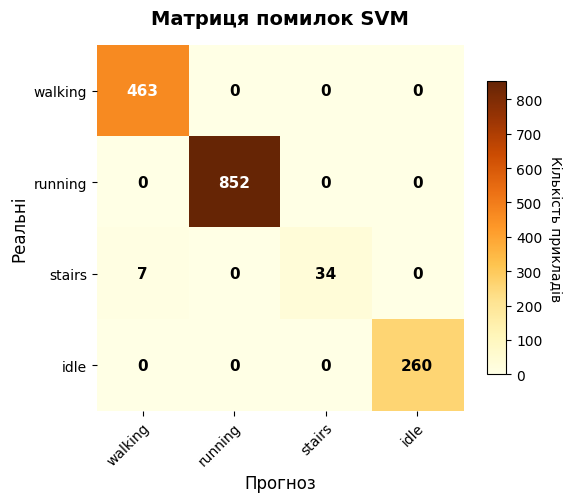

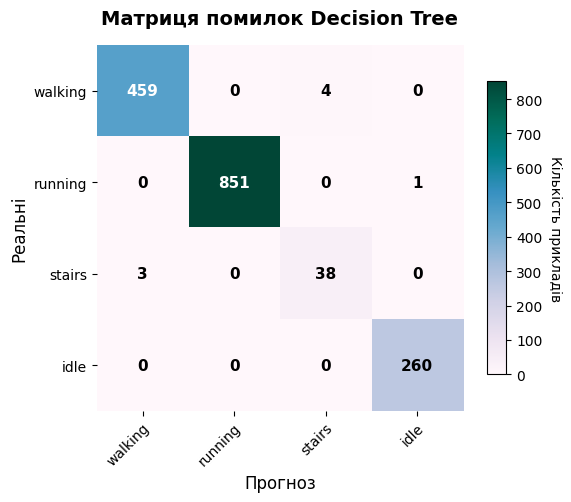

In [27]:
def plot_confusion_simple(y_true, y_pred, labels, title, cmap='YlGnBu'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                    fontsize=11, fontweight='bold')

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Прогноз", fontsize=12)
    ax.set_ylabel("Реальні", fontsize=12)

    cbar = fig.colorbar(im, ax=ax, shrink=0.8, aspect=15)
    cbar.ax.set_ylabel('Кількість прикладів', rotation=-90, va="bottom")

    plt.tight_layout()
    plt.show()

plot_confusion_simple(y_test, y_pred_svm, classes, "Матриця помилок SVM", cmap='YlOrBr')
plot_confusion_simple(y_test, y_pred_tree, classes, "Матриця помилок Decision Tree", cmap='PuBuGn')

8. Підсумкове порівняння моделей

In [28]:
print("Порівняння точності:")
print(f"SVM точність: {svm_clf.score(X_test, y_test):.3f}")
print(f"Decision Tree точність: {tree_clf.score(X_test, y_test):.3f}")

Порівняння точності:
SVM точність: 0.996
Decision Tree точність: 0.995
